## 1. 数据准备

本文的目的是对中化会员数据进行人员分类，使用的算法是kmeans聚类算法与RFM算法，为了进行比对分析，算法均采用客户的三个特征：最近一次消费(Recency)、消费频率(Frequency)、消费金额(Monetary)。本文详细记录了从数据获取到算法实现的过程。

### 获取数据

本文使用的数据集来自会员系统预生产数据库sql server。获取数据过程如下：

1. 登录预生产节点10.144.131.108`> ssh username@10.144.131.108`
2. 进入sqoop文件夹`> cd /opt/cloudera/parcels/CDH-5.9.0-1.cdh5.9.0.p0.23/lib/sqoop/bin`
3. 利用sqoop将sql server中的数据导出`./sqoop import --connect 'jdbc:sqlserver://10.144.129.20:1433; username=username; password=password;database=FCS_DB' --query 'select * from PORTAL_MEMBER where $CONDITIONS' --m 1  --target-dir /user/hive/warehouse/sino_b2c_report.db/PORTAL_MEMBER/dt="2018-3-19";`
4. 查看文件保存成功`hadoop fs -ls /user/hive/warehouse/sino_b2c_report.db/PORTAL_MEMBER`
5. 创建文件夹用于临时保存文件`> mkdir lb`,`> cd lb`
6. 将文件保存在节点本地`hadoop fs -copyToLocal /user/hive/warehouse/sino_b2c_report.db/PORTAL_MEMBER/dt=2018-03-13`
7. 远程下载节点的文件，打开新的终端，执行`> scp -r username@10.144.131.108:./lb/dt=2018-03-13 /Users/freefrog/Downloads
`

以上内容的用户名密码请与大数据组相关人员咨询。

加载需要使用的库。

In [35]:
import pandas as pd
import numpy as np
import linecache
import time
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from IPython.display import display 
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
import math
%matplotlib inline

### 读入数据集

首先读入数据，随机选择一行进行观察。

In [2]:
file_path = '/Users/freefrog/Studing/DataScience/Articles/RMF模型客户细分/dt=2018-03-13/part-m-00000'
the_line = linecache.getline(file_path, 5374)
print(the_line)

5428,华子,,,2009059511111192833,0.00,13559529916,3,140.71,3,970.00,2018-03-05 07:44:55,2018-01-17 18:16:22,2018-03-05 07:44:43,0.00,A008



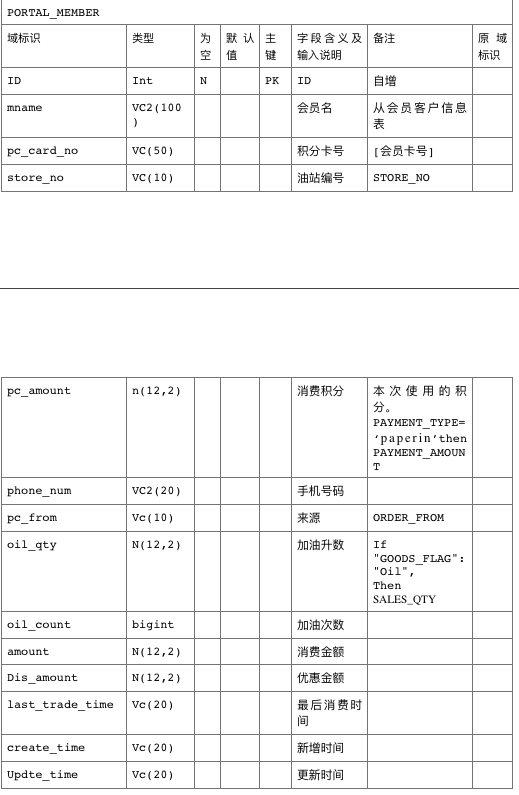

观察上面的数据可知，数据由逗号分隔的值组成，根据字段说明可知，由14组值组成。但是以上一行数据由15个逗号组成，也就是一共有16组值。导致此类问题的原因可能是在会员名‘华子’和积分卡号2009059511111192833之间多了两个逗号，对于此类不符合格式要求的数据，选择删除，因为对于大量数据来说，少几个样本不影响模型效果。

基于上述思考，定义函数`read_and_remove`，输入参数包括一行数据`lines`，该数据由多少值`value_num`组成，分隔符`split_str`是什么。

In [3]:
def read_and_remove(lines, value_num, split_str):
    data = []
    error_data = []
    for cur_line_number, line in enumerate(lines):
        ele = line.split(',')
        key_num = len(ele)
        if key_num is value_num:
            data.append(ele)
        else:
            error_data.append(line)
            print("line %d has been removed."%cur_line_number)
    return data, error_data

In [4]:
fi = open(file_path)
lines = fi.readlines()
data, error_data = read_and_remove(lines, 14, ',')

line 5373 has been removed.
line 20337 has been removed.
line 38901 has been removed.
line 71542 has been removed.
line 93421 has been removed.
line 150205 has been removed.
line 154005 has been removed.
line 165856 has been removed.
line 277531 has been removed.
line 294789 has been removed.
line 303800 has been removed.
line 376176 has been removed.
line 377535 has been removed.


运行后，有13行数据不符合规范被删除。

### 数据清洗

读入的原始数据集没有表头，且数据格式为list，为了方便处理，我们将数据转换为data frame格式，并增加表头。

In [5]:
column_names = ['id',
                'mname', 
                'pc_card_no', 
                'pc_amount', 
                'phone_num', 
                'pc_from', 
                'oil_qty', 
                'oil_count', 
                'amount',
                'last_trade_time',
                'create_time',
                'update_time',
                'Dis_amount',
                'store_no'
               ]
df = pd.DataFrame(data)
df.columns = column_names
df.head()

,id,mname,pc_card_no,pc_amount,phone_num,pc_from,oil_qty,oil_count,amount,last_trade_time,create_time,update_time,Dis_amount,store_no
0,55,18910435767,8888116002000280088,0.00,18910435767,3,0.00,1,0.01,2018-01-16 06:42:17,2018-01-16 06:42:25,null,0.00,W011\n
1,56,姚青林,2009059500000435523,0.00,13606082293,3,90.05,2,625.90,2018-01-16 06:42:37,2018-01-16 06:42:42,2018-01-16 07:04:25,0.00,D001\n
2,57,陈海良,2009059500000308773,0.00,15959870315,3,35.97,1,250.00,2018-01-16 06:43:00,2018-01-16 06:43:11,null,0.00,A008\n
3,58,刘宏渠,2009059500000865033,0.00,13074889976,3,69.52,2,543.49,2018-02-13 23:01:41,2018-01-16 06:43:12,2018-02-13 23:01:56,0.00,D001\n
4,59,王利,2009059500000547131,28.00,13950002846,3,230.55,11,1652.26,2018-03-12 06:33:25,2018-01-16 06:44:50,2018-03-12 06:35:11,24.00,D001\n


我们要做的任务是使用kmeans算法和rfm算法，因此我们只保留会员的四个特征，用于唯一标识会员的`pc_card_no`, 会员的加油次数`oil_count`, 会员的消费金额`amount`, 会员的上次交易时间`last_trade_time`。

In [6]:
columns_to_keep = ['pc_card_no', 'oil_count', 'amount', 'last_trade_time']
df_rfm = df.loc[:, columns_to_keep]
df_rfm.head()

,pc_card_no,oil_count,amount,last_trade_time
0,8888116002000280088,1,0.01,2018-01-16 06:42:17
1,2009059500000435523,2,625.90,2018-01-16 06:42:37
2,2009059500000308773,1,250.00,2018-01-16 06:43:00
3,2009059500000865033,2,543.49,2018-02-13 23:01:41
4,2009059500000547131,11,1652.26,2018-03-12 06:33:25


将数据集的会员号和特征值转换为数字格式。

In [7]:
column_to_num = ['pc_card_no', 'oil_count', 'amount',]
for i in column_to_num:
    df_rfm.loc[:,i] = pd.to_numeric(df_rfm.loc[:,i])

In [8]:
df_rfm.dtypes

pc_card_no          uint64
oil_count            int64
amount             float64
last_trade_time     object
dtype: object

将数据集的`last_trade_time`转换为时间戳格式。

In [9]:
df_rfm['last_trade_time'] = df_rfm.apply(lambda x:pd.Timestamp(x['last_trade_time']), axis=1);

In [10]:
df_rfm.dtypes

pc_card_no                 uint64
oil_count                   int64
amount                    float64
last_trade_time    datetime64[ns]
dtype: object

格式转换完成，我们可以根据上次交易时间，来计算会员上次交易距今天的天数。

In [11]:
current_time = pd.Timestamp(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
last_time = df_rfm.loc[1,'last_trade_time']
(current_time-last_time).days

63

将`last_trade_time`转换为`days_from_last_trade`

In [12]:
df_rfm['days_from_last_trade'] = current_time - df_rfm.loc[:,"last_trade_time"]
df_rfm['days_from_last_trade'] = df_rfm.apply(lambda x:x["days_from_last_trade"].days, axis=1)
df_card_no = df_rfm["pc_card_no"]
df_rfm = df_rfm.drop(["last_trade_time",'pc_card_no'],axis =1)
df_rfm.head()

,oil_count,amount,days_from_last_trade
0,1,0.01,63
1,2,625.90,63
2,1,250.00,63
3,2,543.49,34
4,11,1652.26,8


In [13]:
df_rfm.describe()

,oil_count,amount,days_from_last_trade
count,484099.000000,484099.000000,484099.000000
mean,2.397200,574.033342,23.538503
std,2.667183,1328.790636,14.044198
min,0.000000,0.000000,6.000000
25%,1.000000,225.000000,11.000000
50%,2.000000,400.000000,19.000000
75%,3.000000,720.000000,35.000000
max,630.000000,787316.740000,63.000000


### 异常值检查

删除明显的异常值。

In [14]:
df_rm_outlier = df_rfm.drop(df_rfm[df_rfm['oil_count'] == 630].index)

## 2. 预处理

以上完成了对数据的清洗，接下来进行数据处理。

### 标准化

对数据集进行标准化处理。

In [15]:
df_std = 1.0 * (df_rm_outlier - df_rm_outlier.mean()) / df_rm_outlier.std()

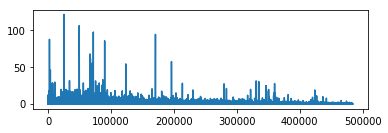

In [16]:
plt.figure(1)
plt.subplot(211)
plt.plot(df_std['oil_count'])
plt.show()

由于数据集中存在大量数值较大的数据，因此需要进行非线性转换处理。

### 非线性转换

In [17]:
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal',random_state=0)
df_trans = quantile_transformer.fit_transform(df_rm_outlier)

In [18]:
df_trans[1:5]

array([[ 0.18547963,  0.51866179,  5.19933758],
       [-0.7152178 , -0.54088248,  5.19933758],
       [ 0.18547963,  0.35681376,  0.61957818],
       [ 2.36524765,  1.72736549, -1.34638564]])

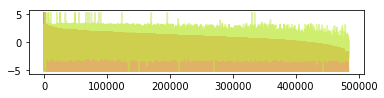

In [19]:
plt.figure(1)
plt.subplot(311)
plt.plot(df_trans[:,2],color="#FF0000", alpha=.5)
plt.plot(df_trans[:,1],color="#C1F320", alpha=.5)
plt.plot(df_trans[:,0],color="#C1E550", alpha=.5)
plt.show()

数据得到了较好的转换。

## 模型

### RFM模型

接下来使用传统的RFM模型进行用户分类，注意这里使用的是原始数据，而非预处理后的数据。

首先计算RFM得分

In [55]:
df_rfm = (df_rm_outlier - df_rm_outlier.min()) / ((1/3)*(df_rm_outlier.max() - df_rm_outlier.min()))
df_rfm = df_rfm.apply(np.ceil).replace(0,1)
df_rfm.columns = ['F-Score','M-Score','R-Score']
df_rfm.head()

,F-Score,M-Score,R-Score
0,1.0,1.0,3.0
1,1.0,1.0,3.0
2,1.0,1.0,3.0
3,1.0,1.0,2.0
4,1.0,1.0,1.0


增加RFM-score列，用于区分不同用户。

In [56]:
df_rfm['RFM-score'] = 100*df_rfm['F-Score'] + 10 *df_rfm['M-Score'] + df_rfm['R-Score']
df_rfm.head()

,F-Score,M-Score,R-Score,RFM-score
0,1.0,1.0,3.0,113.0
1,1.0,1.0,3.0,113.0
2,1.0,1.0,3.0,113.0
3,1.0,1.0,2.0,112.0
4,1.0,1.0,1.0,111.0


根据RFM-score统计不同类别的用户。

In [65]:
rfm_custmer = {}
for score in df_rfm['RFM-score'].unique():
    rfm_custmer[score] = sum(df_rfm['RFM-score'] == score)
rfm_custmer

{111.0: 299301,
 112.0: 131881,
 113.0: 52902,
 121.0: 2,
 211.0: 6,
 311.0: 3,
 321.0: 1,
 331.0: 2}

分析上述结果，关键字有一个三位数组成，其中第一位代表F-Score也就是顾客光顾的频率得分，分为3个等级1、2、3，1代表不经常光顾，3代表经常光顾。其他两位数以此类推。   
基于上述讨论，我们以RFM模型得到的113类人群为例讨论，该类人群为低价值人群，即消费频率和额度较小距离上次消费时间较长。   
321和331可以定义为忠诚度较高的人群，消费水平高，且距上一次消费时间短。

### RFM的问题

RFM的问题很明显，由于分类得分采取的方式是“三分位法”（真实值减去最小值除以三分位值），因此该算法受异常值影响较大，我们也可以从得到的结果中看到，人群的分布很不均匀。

 ### k-means聚类

接下来采用k-means聚类，该算法只有一个超参数k，即聚类的数目，我们首先使用k=3来测试。

In [66]:
k = 3
model = KMeans(n_clusters= k,  random_state=0)
clusterer = model.fit(df_trans)

preds = clusterer.predict(df_trans)

centers = clusterer.cluster_centers_

下面看一下，各类别得到的数量

In [67]:
for i in range(k):
    print(len(preds[preds[:]==i])) 

126878
174211
183009


In [68]:
centers

array([[ 1.18774942,  1.19247056, -0.91778703],
       [-0.73173895, -0.8409535 ,  0.91227998],
       [-0.05384738, -0.02794216, -0.31298162]])

观察上面的聚类中心点的位置，可以粗略得到该类人群的特征。

In [69]:
df_kmeans = pd.DataFrame(df_trans, columns = ['oil_count','amount','days_from_last_trade'])
df_kmeans['Cluster'] = preds
df_kmeans.head()

,oil_count,amount,days_from_last_trade,Cluster
0,-0.715218,-5.199338,5.199338,1
1,0.185480,0.518662,5.199338,1
2,-0.715218,-0.540882,5.199338,1
3,0.185480,0.356814,0.619578,2
4,2.365248,1.727365,-1.346386,0


上述代码为对应客户标记聚类类别

为了可视化聚类效果，以下定义一个3d作图函数。

In [70]:
def kmeans_plot(data):
    ax = plt.subplot(111, projection='3d') 

    # 3d plot
    for i, cluster in data.groupby('Cluster'):   
        ax.scatter(cluster['oil_count'], cluster['amount'], cluster['days_from_last_trade'], 
                   cmap = (i)*1.0/(len(centers)-1))
    # set lables
    ax.set_zlabel('Z');ax.set_ylabel('Y');ax.set_xlabel('X')
    plt.show()
    return plt

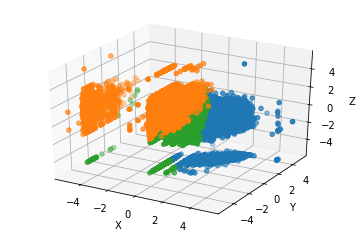

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [71]:
kmeans_plot(df_kmeans)

直观观察结果，分类效果尚可，对于左侧的一组客户规划为一类，最下面的一组客户规划为一类，是较好的结果，但是对于中间集中在一起的分类方式并不合理。由于k-means算法具有随机性，因此可能导致分类结果的不稳定性。这也是k-means算法的缺点之一。

## 结果分析

为了方便分析结果，我们观察各个类别的统计值。以下定义函数输出各类别的统计值并作图。

In [72]:
def density_plot(data):  
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    p = data.plot(kind='kde', linewidth=2, subplots=True, sharex=False)#subplots = True制作子图 sharex = False是不共享X轴刻度
    plt.legend() #加不加这句代码都不影响
    return plt

In [73]:
df_rm_outlier['Cluster'] = df_kmeans['Cluster']

这里需要注意，作图使用的是原始数据而非预处理后的数据。

In [74]:
df_rm_outlier.head()

,oil_count,amount,days_from_last_trade,Cluster
0,1,0.01,63,1.0
1,2,625.90,63,1.0
2,1,250.00,63,1.0
3,2,543.49,34,2.0
4,11,1652.26,8,0.0


In [75]:
def statistic_plot(data):
    for i in range(k):
        df_temp = data[data['Cluster'] == i].loc[:, data.columns != 'Cluster']
        density_plot(df_temp)
        print(np.mean(df_temp))
    return None

oil_count                 3.452056
amount                  830.445816
days_from_last_trade     23.521777
dtype: float64
oil_count                 2.116124
amount                  504.187857
days_from_last_trade     26.611567
dtype: float64
oil_count                 1.930020
amount                  458.455963
days_from_last_trade     20.624975
dtype: float64


/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


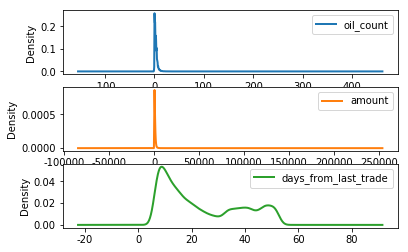

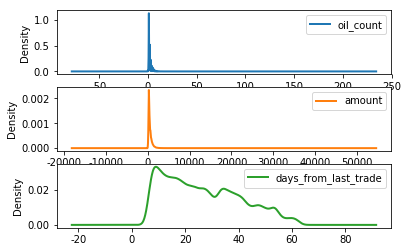

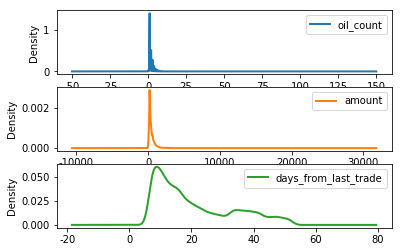

In [78]:
statistic_plot(df_rm_outlier)

三组客户描述：

1. 第2组客户加油次数不多，约2.1次；消费金额不高，约500元；相较于其他类型客户，该类型客户距上次加油时间较长，均值25天。所以该类客户可以定义为低价值易流失客户
2. 第1组客户加油次数和加油量均较多，平均3.49次，消费额838.37。且经常光顾，定义为老客户。
3. 第3组客户虽然加油次数和金额不高，但是最近还在光顾，属于新客户的范畴。

## 模型改进

### k-means的改进

观察上述结果，不同组的客户，上次交易时间的分布类似于双峰分布，因此，判断聚类可以再分，6类较合适。

In [79]:
k = 6
model2 = KMeans(n_clusters= k,  random_state=0)
clusterer2 = model2.fit(df_trans)

preds2 = clusterer2.predict(df_trans)

centers2 = clusterer2.cluster_centers_

In [80]:
centers2

array([[-0.64313126, -0.70447338,  1.10149812],
       [ 0.42082026,  0.42833014, -0.0901265 ],
       [ 1.33625618,  1.33250898, -0.95196139],
       [-0.64848644, -0.79285553, -0.46551925],
       [ 0.69523527,  0.6307284 , -5.19933758],
       [-5.19933758, -2.46728729,  0.41169526]])

In [81]:
df_kmeans2 = pd.DataFrame(df_trans, columns = ['oil_count','amount','days_from_last_trade'])
df_kmeans2['Cluster'] = preds2
df_kmeans2.head()

,oil_count,amount,days_from_last_trade,Cluster
0,-0.715218,-5.199338,5.199338,0
1,0.185480,0.518662,5.199338,0
2,-0.715218,-0.540882,5.199338,0
3,0.185480,0.356814,0.619578,1
4,2.365248,1.727365,-1.346386,2


/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


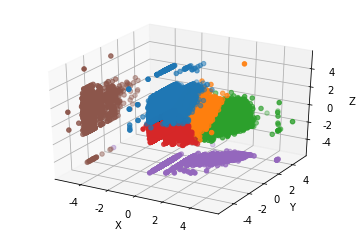

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [82]:
kmeans_plot(df_kmeans2)

In [83]:
df_rm_outlier2 = df_rm_outlier.copy()
df_rm_outlier2['Cluster'] = df_kmeans2['Cluster']

oil_count                 2.275926
amount                  542.550429
days_from_last_trade     28.397367
dtype: float64
oil_count                 2.476341
amount                  589.962840
days_from_last_trade     25.315950
dtype: float64
oil_count                 3.679144
amount                  885.989058
days_from_last_trade     23.038821
dtype: float64
oil_count                 1.271673
amount                  301.273841
days_from_last_trade     14.675071
dtype: float64
oil_count                 2.767227
amount                  661.611166
days_from_last_trade     17.723628
dtype: float64
oil_count                 1.813238
amount                  442.032312
days_from_last_trade     23.207893
dtype: float64


/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


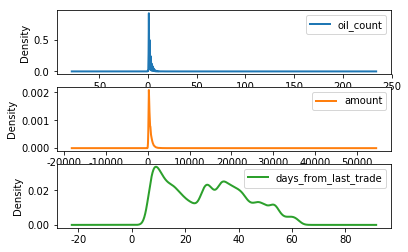

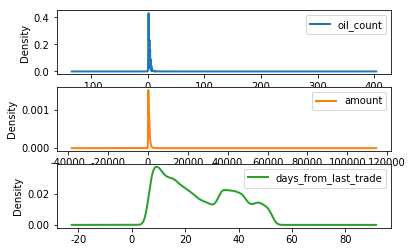

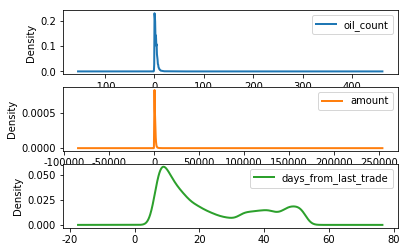

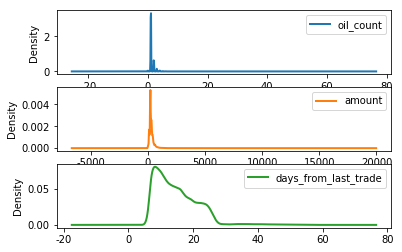

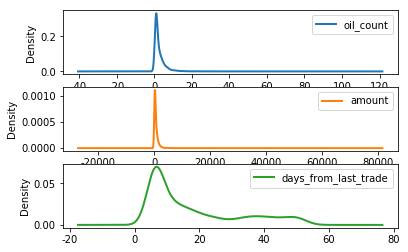

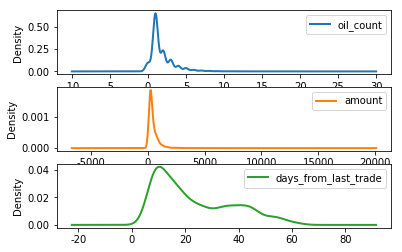

In [84]:
statistic_plot(df_rm_outlier2)

首先我们可以根据距离上一次的消费时间来定义客户，第1组客户时间最长，我们定义为已流失。第2组可是时间第二长，我们定义为即将流失。

再来看距离上一次消费时间较短的客户，即第4组和第5组用户，其中第4组客户，消费的次数和额度较小，可以定义为价格敏感型客户，而第5组客户消费的次数和额度较大，可以定义为忠诚度较高的高价值用户。

第3组客户的消费频次和消费额最大，但是距离上一次加油时间较长，可以定义为需要召回的高价值客户。

第6组客户相对第三组客户来说消费频次和额度较小，距离上一次加油时间却同样长，所以定义为低价值客户。

### 下一步工作

1. 改进k-means算法，提高模型稳定性
2. 找到合适的测量标准，评判模型效果
3. 使用其他算法进行比对分析，例如层次聚类等